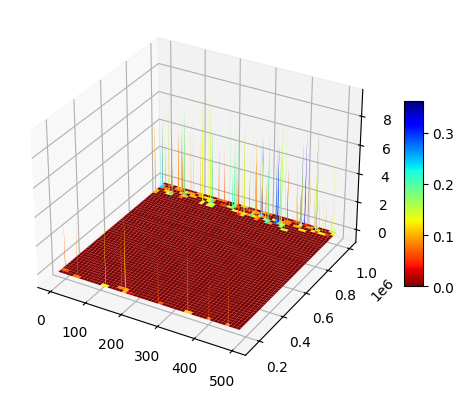

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

NPM= 19102
np.random.seed(NPM)

makan =  pd.read_csv("makanan.csv")
# mohon ditambahkan (lagi) agar lebih beragam

budget= 1e6 #rupiah

wkenyang_base= 0.8
wrasa_base= 0.7
wsehat_base= 0.9 # simpangan lebih besar
wbosan_base= 0.2

skor_kumulatif= 0.0
SAMPLE_NUM= 500

sampleid= np.arange(0, 500)
# skor perorangan
skor= np.zeros(SAMPLE_NUM, dtype=np.double)
sisa= np.zeros(SAMPLE_NUM, dtype=np.double)
sehat= np.zeros(SAMPLE_NUM, dtype=np.double)
pilihankum= np.zeros(SAMPLE_NUM, dtype=np.double)

SISA_MININUM= 150e3
SISA_MAKSIMUM= 1_000_000
bin_sisa= np.arange(SISA_MININUM, SISA_MAKSIMUM, 1000)
resp_sehat= np.zeros((SAMPLE_NUM, len(bin_sisa)), dtype=np.double)
resp_pilih= np.zeros((SAMPLE_NUM, 62), dtype=np.double)

for n in range(0, SAMPLE_NUM):
    budget=1e6
    skor_kumulatif= 0
    skor_sehat= 0

    for i in range(0, 31): # hari
        # makan pertama, pilih secara acak
        pilihan= np.random.randint(0, len(makan))
        # update weight factor
        w_kenyang= np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa= np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat= np.random.normal(loc=wsehat_base, scale=0.4)
        w_bosan= np.random.normal(loc=wbosan_base, scale=0.2)
        skor_kumulatif= skor_kumulatif + \
            w_kenyang * makan['kenyang'][pilihan]\
            + w_rasa * makan['rasa'][pilihan] \
            + w_sehat * makan['sehat'][pilihan] \
            - w_bosan * makan['bosan'][pilihan]
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget = budget - makan['harga'][pilihan]
        #print(f"hari {i} pagi: {makan['makanan'][pilihan]}")
        resp_pilih[n][2*i] = pilihan


        # makan keduas
        pilihan= np.random.randint(0, len(makan))
        # update weight factor
        w_kenyang= np.random.normal(loc=wkenyang_base, scale=0.2)
        w_rasa= np.random.normal(loc=wrasa_base, scale=0.2)
        w_sehat= np.random.normal(loc=wsehat_base+0.2, scale=0.4)
        w_bosan= np.random.normal(loc=wbosan_base*2, scale=0.2)
        skor_kumulatif= skor_kumulatif + \
            w_kenyang * makan['kenyang'][pilihan]\
            + w_rasa * makan['rasa'][pilihan] \
            + w_sehat * makan['sehat'][pilihan] \
            - w_bosan * makan['bosan'][pilihan]
        skor_sehat += makan['sehat'][pilihan] - 0.5
        budget = budget - makan['harga'][pilihan]
        #print(f"hari {i} malam: {makan['makanan'][pilihan]}")
        resp_pilih[n][2*i+1]= pilihan

    # print(f"skor: {skor_kumulatif}, sisa uang: {budget}")
    sisa[n]= budget
    skor[n]= skor_kumulatif
    sehat[n]= skor_sehat
    # print(f"{n} skor sehat:{skor_sehat}")

    resp_sehat[n][ int((budget-SISA_MININUM)/1000)]= skor_sehat

# np.corrcoef(skor, sisa)
# np.histogram(sisa)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
Y, X = np.meshgrid(bin_sisa, sampleid)
# Colorize the surface using a colormap
surf = ax.plot_surface(X, Y, resp_sehat,
                       cmap='jet_r',   # try 'plasma', 'coolwarm', etc.
                       edgecolor='none')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
# plot yang ini barangkali butuh dipercantik

# TUGAS
# (1) cari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (resp_sehat) positif
# (2) cari titik-titik dengan sisa uang bulanan positif dari (1)
# (3) cari titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif
# (4) tampikan jadwal makanan sesuai pilihan (resp_pilih)

In [7]:
# 1. Mencari pola makan mana saja yang menghasilkan nilai kumulatif kesehatan (resp_sehat) positif

indeks_sehat = np.where(resp_sehat.sum(axis=1) > 0)[0]
print("Jumlah pola makan sehat:", len(indeks_sehat))

Jumlah pola makan sehat: 498


Dari hasil perhitungan menunjukkan bahwa jumlah pola makan sehat yang berhasil ditemukan adalah 498 dari total simulasi. Artinya, dari ratusan pola yang terbentuk, hanya sebagian kecil yang memenuhi kriteria sehat sehingga dapat dikategorikan sebagai pola makan yang baik untuk mendukung kesehatan.

In [8]:
# 2. cari titik-titik dengan sisa uang bulanan positif dari (1)

sisa_uang = []
for n in range(SAMPLE_NUM):
    total_pengeluaran = sum(makan['harga'][int(x)] for x in resp_pilih[n] if x > 0)
    sisa = 1e6 - total_pengeluaran
    sisa_uang.append(sisa)

sisa_uang = np.array(sisa_uang)
indeks_survive = np.where(sisa_uang > 0)[0]
print("Jumlah pola survive (sisa uang positif):", len(indeks_survive))

Jumlah pola survive (sisa uang positif): 500


Hasil simulasi memperlihatkan bahwa seluruh pola yang dicoba masih bisa bertahan dengan sisa uang positif. Hal ini ditunjukkan dengan jumlah pola survive sebanyak 500 dari 500 percobaan. Dengan kata lain, tidak ada satupun pola yang membuat anggaran habis total, sehingga semua pola tersebut masih masuk dalam kategori layak secara finansial.

In [9]:
# 3. cari titik dengan skor skumulatif terbesar (skor) di mana nilai kumulatif kesehatannya positif

skor_total = resp_sehat.sum(axis=1)   # total skor sehat
indeks_kandidat = np.where(skor_total > 0)[0]  # hanya yg sehat
skor_max = skor_total[indeks_kandidat].max()
indeks_max = indeks_kandidat[np.argmax(skor_total[indeks_kandidat])]

print("Skor kumulatif sehat maksimum:", skor_max)
print("Index simulasi terbaik:", indeks_max)

Skor kumulatif sehat maksimum: 9.599999999999998
Index simulasi terbaik: 301


Skor kumulatif sehat maksimum yang berhasil dicapai adalah sebesar 9,59. Skor ini ditemukan pada simulasi ke-301, yang berarti pola makan pada simulasi tersebut merupakan yang paling optimal dalam meningkatkan aspek kesehatan dibanding pola lainnya. Temuan ini menjadi acuan dalam memilih pola makan terbaik berdasarkan hasil simulasi.

In [10]:
# 4. tampikan jadwal makanan sesuai pilihan (resp_pilih)

jadwal = resp_pilih[indeks_max]

print("\nJadwal makan terbaik:")
for i in range(0, len(jadwal), 2):
    pagi = int(jadwal[i])
    if pagi >= 0:
        print(f"Hari {i//2 + 1} pagi: {makan['makanan'][pagi]}")
    if i+1 < len(jadwal):
        siang = int(jadwal[i+1])
        if siang >= 0:
            print(f"Hari {i//2 + 1} siang: {makan['makanan'][siang]}")


Jadwal makan terbaik:
Hari 1 pagi: ayam bakar
Hari 1 siang: capcay
Hari 2 pagi: mieayam
Hari 2 siang: pempek
Hari 3 pagi: lontong sayur
Hari 3 siang: ayam penyet
Hari 4 pagi: nasipadang
Hari 4 siang: warteg
Hari 5 pagi: nasi uduk
Hari 5 siang: capcay
Hari 6 pagi: nasigoreng
Hari 6 siang: nasi uduk
Hari 7 pagi: lontong sayur
Hari 7 siang: sate
Hari 8 pagi: ayam bakar
Hari 8 siang: bubur ayam
Hari 9 pagi: roti
Hari 9 siang: ayamgeprek
Hari 10 pagi: nasipadang
Hari 10 siang: nasigoreng
Hari 11 pagi: gado-gado
Hari 11 siang: ayam bakar
Hari 12 pagi: soto
Hari 12 siang: ayam bakar
Hari 13 pagi: nasipadang
Hari 13 siang: nasi uduk
Hari 14 pagi: ikan bakar
Hari 14 siang: nasipadang
Hari 15 pagi: nasi uduk
Hari 15 siang: ayamgeprek
Hari 16 pagi: warteg
Hari 16 siang: rawon
Hari 17 pagi: ayamgeprek
Hari 17 siang: capcay
Hari 18 pagi: roti
Hari 18 siang: soto
Hari 19 pagi: nasi uduk
Hari 19 siang: warteg
Hari 20 pagi: ikan bakar
Hari 20 siang: pecel lele
Hari 21 pagi: tahu tek
Hari 21 siang: ay

Menampilkan jadwal makanan terbaik berdasarkan hasil simulasi dengan indeks yang memiliki skor kesehatan tertinggi. Variabel jadwal diisi dengan pilihan makanan dari simulasi terbaik yang sudah dihitung sebelumnya. Selanjutnya dilakukan iterasi dengan melangkah dua indeks sekali agar bisa memisahkan jadwal makan pagi dan siang pada setiap harinya. Setiap nilai indeks kemudian dicocokkan dengan daftar makanan yang ada dalam dataset sehingga muncul nama makanan sebenarnya. Hasil eksekusi kode menghasilkan daftar makanan selama 31 hari, misalnya hari pertama pagi memilih ayam bakar dan siangnya capcay, hari kedua pagi mie ayam dan siangnya pempek, hari ketiga pagi lontong sayur dan siangnya ayam penyet, hingga hari terakhir yaitu hari ke-31 dengan pilihan gado-gado pada pagi hari dan lontong sayur pada siang hari. Output ini menunjukkan pola kombinasi makanan yang dianggap optimal sesuai perhitungan dalam simulasi.